<a href="https://colab.research.google.com/github/TomoharuKurosu/TomoharuKurosu/blob/main/%E6%A0%AA%E5%BC%8F%E8%87%AA%E5%8B%95%E5%A3%B2%E8%B2%B7%E3%82%B7%E3%82%B9%E3%83%86%E3%83%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 各種準備

In [ ]:
from google.colab import drive,output
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/松尾研サマースクール/Day05
#自分の環境で変える

/content/drive/MyDrive/松尾研サマースクール/Day05


In [ ]:
%pip install mlbacktester-0.0.7-py3-none-any.whl
%pip install lightgbm optuna pandas-ta japanize_matplotlib IPython
output.clear()

In [ ]:
#data_analysis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pickle
from tqdm import tqdm
import lightgbm as LGB
from sklearn.metrics import log_loss

#financial
import copy
import pandas_ta as ta
from statsmodels.tsa.stattools import adfuller #定常性判定
import numbers #エンバーゴありCPCV
import itertools as itt #
from abc import abstractmethod #
from typing import Iterable, Tuple, List #
import optuna #パラメータ探索
optuna.logging.set_verbosity(optuna.logging.WARNING)

#competition
from mlbacktester import Order, BaseStrategy, Scoring
from mlbacktester.bt import BackTester
from mlbacktester.utils.custom_types import AssetInfo

import time
import datetime
from datetime import timedelta
from importlib import import_module
from typing import Any

from mlbacktester import bt, load_cfg
from pandas.testing import assert_frame_equal

In [ ]:
# seedを固定する
np.random.seed(42)

In [ ]:
with open("/content/drive/MyDrive/松尾研サマースクール/Day05/data/public.pkl", "rb") as f:
  df=pickle.load(f)

In [ ]:
len(df)

17544

In [ ]:
df.tail()

,open,high,low,close,volume
timestamp,,,,,
2021-12-31 19:00:00,48279.00,48434.89,47863.81,48012.03,11404.457
2021-12-31 20:00:00,48012.04,48196.94,47895.68,47977.58,10649.207
2021-12-31 21:00:00,47977.58,48100.00,47810.00,47977.99,8575.832
2021-12-31 22:00:00,47975.17,48075.00,47876.37,47943.72,5718.212
2021-12-31 23:00:00,47943.72,48140.18,47829.21,47974.86,8919.171


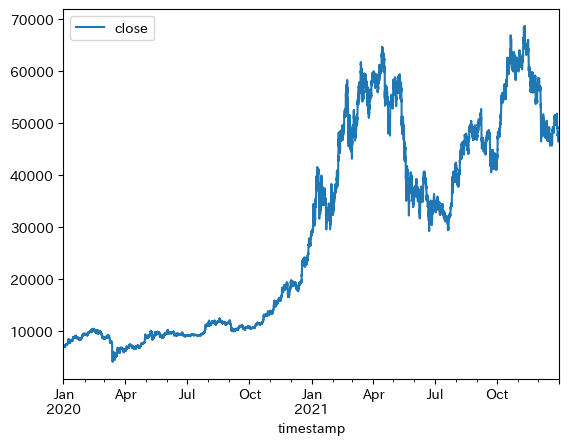

In [ ]:
df["close"].plot(label="close")
plt.legend()
plt.show()

# テクニカル分析の実験

## 移動平均線

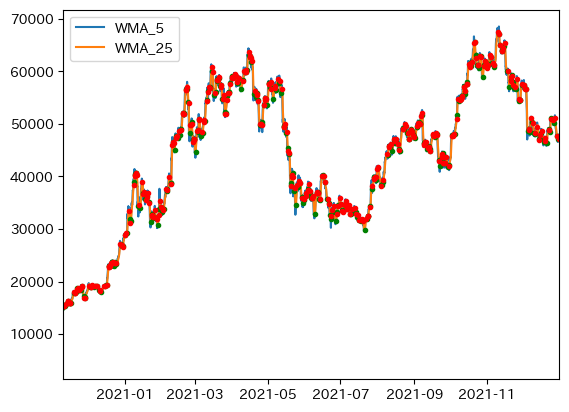

644 644


In [ ]:
sma5=ta.wma(df["close"],length=5)
sma25=ta.wma(df["close"],length=25)

for col in [sma5,sma25]:
  plt.plot(col,label=f"{col.name}")

diff5_25=sma5-sma25
gold5_25=np.where((np.sign(diff5_25) - np.sign(diff5_25.shift(1)) == 2), 1, 0)
dead5_25=np.where((np.sign(diff5_25) - np.sign(diff5_25.shift(1)) == -2), 1, 0)

gold=sma5[np.where(gold5_25,True,False)]
dead=sma5[np.where(dead5_25,True,False)]
plt.plot(gold,"go",markersize=3)
plt.plot(dead,"ro",markersize=3)
plt.xlim(df.index[-10000],df.index[-1])
plt.legend()
plt.show()
print(len(gold),len(dead))

## 一目均衡表

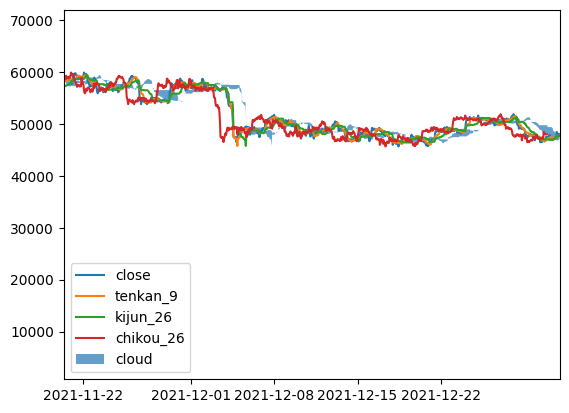

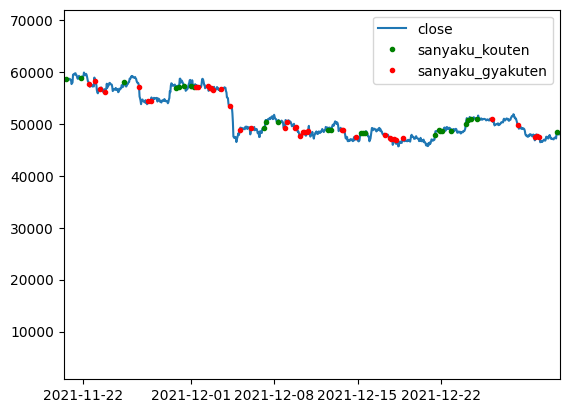

522 429


In [ ]:
ich,ich2=ta.ichimoku(df["high"],df["low"],df["close"],tenkan=9,kijun=26,senkou=52,include_chikou=True)
plt.plot(df["close"],label="close")
tenkan,kijun,chikou,senkou1,senkou2=ich["ITS_9"],ich["IKS_26"],ich["ICS_26"],ich["ISA_9"],ich["ISB_26"]
plt.plot(tenkan,label="tenkan_9")
plt.plot(kijun,label="kijun_26")
plt.plot(chikou,label="chikou_26")
plt.fill_between(ich.index,senkou1,senkou2,alpha=0.7,label="cloud")

diff=senkou1-senkou2
cloud_high=pd.Series(np.where(diff>0,senkou1,senkou2),index=senkou1.index)
cloud_low=pd.Series(np.where(diff>0,senkou2,senkou1),index=senkou1.index)

diff=(tenkan-kijun).replace(to_replace=0, method='ffill')
gold1=np.where((np.sign(diff) - np.sign(diff.shift(1)) == 2), 1, 0)
dead1=np.where((np.sign(diff) - np.sign(diff.shift(1)) == -2), -1, 0)

diff=(df["close"]-cloud_high).replace(to_replace=0, method='ffill')
gold2=np.where((np.sign(diff) - np.sign(diff.shift(1)) == 2), 1, 0)
diff=(df["close"]-cloud_high).replace(to_replace=0, method='ffill')
dead2=np.where((np.sign(diff) - np.sign(diff.shift(1)) == -2), -1, 0)

diff=(chikou-df["close"]).replace(to_replace=0, method='ffill')
gold3=np.where((np.sign(diff) - np.sign(diff.shift(1)) == 2), 1, 0)
diff=(chikou-df["close"]).replace(to_replace=0, method='ffill')
dead3=np.where((np.sign(diff) - np.sign(diff.shift(1)) == -2), -1, 0)

cond1=pd.Series(gold1+dead1).replace(to_replace=0,method="ffill")
cond2=pd.Series(gold2+dead2).replace(to_replace=0,method="ffill")
cond3=pd.Series(gold3+dead3).replace(to_replace=0,method="ffill")
cond=pd.Series(np.where((cond1+cond2+cond3)==3,1,0))
kouten=df["close"][np.where((cond-cond.shift(1))==1,True,False)]
cond=pd.Series(np.where((cond1+cond2+cond3)==-3,1,0))
gyakuten=df["close"][np.where((cond-cond.shift(1))==1,True,False)]

plt.xlim(df.index[-1000],df.index[-1])
plt.legend()
plt.show()

plt.plot(df["close"],label="close")
plt.plot(kouten,"go",markersize=3,label="sanyaku_kouten")
plt.plot(gyakuten,"ro",markersize=3,label="sanyaku_gyakuten")

plt.xlim(df.index[-1000],df.index[-1])
plt.legend()
plt.show()
print(len(kouten),len(gyakuten))

## ボリンジャーバンド

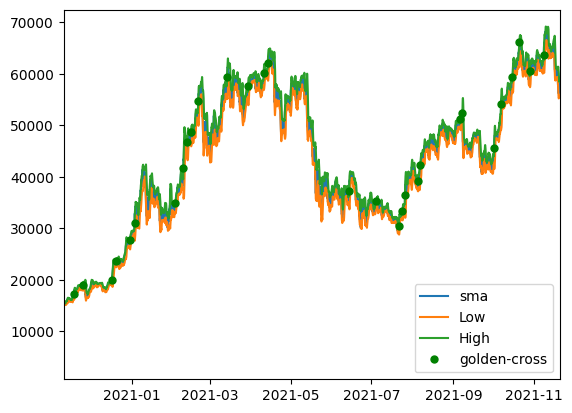

70 61


In [ ]:
sma5=ta.wma(df["close"],length=5)
bbands2 = ta.bbands(df["close"], length=25, std=2)
plt.plot(sma5,label="sma")
plt.plot(bbands2["BBL_25_2.0"],label="Low")
plt.plot(bbands2["BBU_25_2.0"],label="High")

diff_sma_high=(sma5-bbands2["BBU_25_2.0"]).replace(to_replace=0, method='ffill')
diff_sma_low=(sma5-bbands2["BBL_25_2.0"]).replace(to_replace=0, method='ffill')
gold_bbands=np.where((np.sign(diff_sma_high) - np.sign(diff_sma_high.shift(1)) == 2), 1, 0)
dead_bbands=np.where((np.sign(diff_sma_low) - np.sign(diff_sma_low.shift(1)) == -2), 1, 0)

gold_bbands=sma5[np.where(gold_bbands,True,False)]
dead_bbands=sma5[np.where(dead_bbands,True,False)]
plt.plot(gold_bbands,"go",markersize=5,label="golden-cross")
plt.plot(dead_bbands,"ro",markersize=5,label="dead-cross")

plt.xlim(df.index[-10000],df.index[-1000])
plt.legend()
plt.show()
print(len(gold_bbands),len(dead_bbands))

## RSI

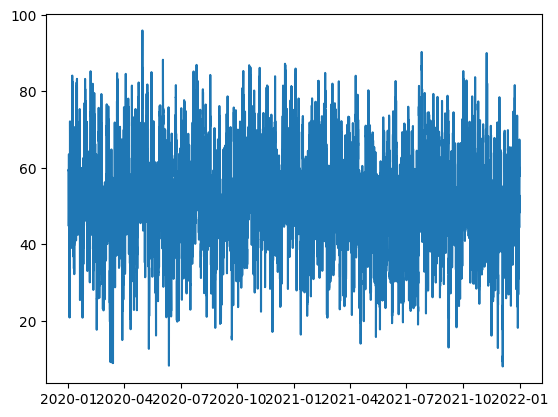

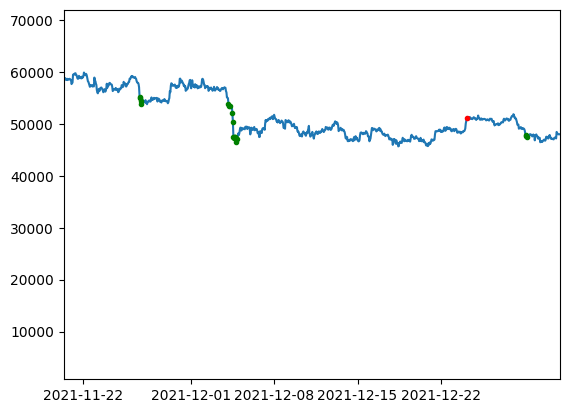

170 97


In [ ]:
rsi14 = ta.rsi(df["close"],length=14)
plt.plot(rsi14)
plt.show()
sell_rsi=df["close"][rsi14>70]
buy_rsi=df["close"][rsi14<30]
plt.plot(df["close"])
plt.plot(sell_rsi,"ro",markersize=3)
plt.plot(buy_rsi,"go",markersize=3)
plt.xlim(df.index[-1000],df.index[-1])
plt.show()
print(len(sell_rsi),len(buy_rsi))

# 特徴量作成、一次モデル予測

In [ ]:
## AFML Snipet 3.1

# 日次ボラティリティの計算
def get_daily_vol(close, span0=50):
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0 - 1],
                    index=close.index[close.shape[0] - df0.shape[0]:])

    #それぞれの時刻における1日前のリターンを算出
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1
    #ローリング指数加重標準偏差を計算
    df0 = df0.ewm(span=span0).std()
    return df0.rename('daily_vol')

In [ ]:
def calc_features(df):
    df_ = df.copy()

    # pandas_taの入力は必ずpandas series
    close = df_['close']
    open = df_['open']
    high = df_['high']
    low = df_['low']
    volume = df_['volume']

    ####################################
    # トレンド系指標 #
    ####################################

    #単純移動平均
    df_['SMA5'] = ta.sma(close, length=5) / close
    df_['SMA10'] = ta.sma(close,length=10) / close
    df_['SMA25'] = ta.sma(close,length=25) / close

    #加重移動平均
    df_['WMA5'] = ta.wma(close,length=5) / close
    df_['WMA10'] = ta.wma(close,length=10) / close
    df_['WMA25'] = ta.wma(close,length=25) / close

    #指数加重移動平均
    df_['EMA5'] = ta.ema(close,length=5) / close
    df_['EMA10'] = ta.ema(close,length=10) / close
    df_['EMA25'] = ta.ema(close,length=25) / close

    #モメンタム
    df_['MOM7'] = ta.mom(close,length=7) / close

    #ROC(変化率)
    df_['ROC10'] = ta.roc(close,length=10)

    # 回帰
    df_['REG'] = ta.linreg(close,length=5) / close

    df_['ATR'] = ta.atr(df_['high'], df_['low'], close, length=14) / close

    diff = df_["WMA5"] - df_["WMA25"]
    gold = np.where((np.sign(diff) - np.sign(diff.shift(1)) == 2), 1, 0) # ゴールデンクロス
    dead = np.where((np.sign(diff) - np.sign(diff.shift(1)) == -2), -1, 0) # デッドクロス
    wma_signal = gold + dead

    ####################################
    # オシレータ系指標 #
    ####################################

    #RSI(Relative Strength Index)
    df_['RSI5'] = ta.rsi(close,length=5)
    df_['RSI14'] = ta.rsi(close,length=14)

    rsi_sell=np.where(df_["RSI14"]>80,-1,0) #買われすぎ
    rsi_buy=np.where(df_["RSI14"]<20,1,0) #売られすぎ
    rsi_signal=rsi_sell+rsi_buy

    #ストキャスティック
    stoch = ta.stoch(df_['high'], df_['low'], close, k=14, d=3)
    df_ = pd.concat([df_, stoch], axis=1)

    #Bollinger Bands
    bbands1 = ta.bbands(close, length=25, std=1)
    bbands2 = ta.bbands(close, length=25, std=2)
    bbands3 = ta.bbands(close, length=25, std=3)

    wma5=ta.wma(close,length=5)
    diff_sma_high=(wma5-bbands2["BBU_25_2.0"]).replace(to_replace=0, method='ffill')
    diff_sma_low=(wma5-bbands2["BBL_25_2.0"]).replace(to_replace=0, method='ffill')
    bbands_sell=np.where((np.sign(diff_sma_high) - np.sign(diff_sma_high.shift(1)) == 2), -1, 0) #買われすぎ
    bbands_buy=np.where((np.sign(diff_sma_low) - np.sign(diff_sma_low.shift(1)) == -2), 1, 0) #売られすぎ
    bbands_signal=bbands_sell+bbands_buy

    for bbands in [bbands1, bbands2, bbands3]:
        for i, col in enumerate(bbands.columns):
            if i < 3:
                bbands[col] /= close

    df_ = pd.concat([df_, bbands1, bbands2, bbands3], axis=1)

    #MACD
    macd = ta.macd(close, fast=12, slow=26, signal=9)

    for col in macd.columns:
        macd[col] /= close

    df_ = pd.concat([df_, macd], axis=1)

    ####################################
    # サイクル系指標 #
    ####################################

    #一目均衡表
    ich,_ = ta.ichimoku(high,low,close,tenkan=9,kijun=26,senkou=52,include_chikou=True)
    tenkan,kijun,chikou,senkou1,senkou2=ich["ITS_9"],ich["IKS_26"],ich["ICS_26"],ich["ISA_9"],ich["ISB_26"]

    diff=senkou1-senkou2
    cloud_high=pd.Series(np.where(diff>0,senkou1,senkou2),index=senkou1.index)
    cloud_low=pd.Series(np.where(diff>0,senkou2,senkou1),index=senkou1.index)

    diff=(tenkan-kijun).replace(to_replace=0, method='ffill')
    gold1=np.where((np.sign(diff) - np.sign(diff.shift(1)) == 2), 1, 0)
    dead1=np.where((np.sign(diff) - np.sign(diff.shift(1)) == -2), -1, 0)

    diff=(close-cloud_high).replace(to_replace=0, method='ffill')
    gold2=np.where((np.sign(diff) - np.sign(diff.shift(1)) == 2), 1, 0)
    diff=(close-cloud_high).replace(to_replace=0, method='ffill')
    dead2=np.where((np.sign(diff) - np.sign(diff.shift(1)) == -2), -1, 0)

    diff=(chikou-close).replace(to_replace=0, method='ffill')
    gold3=np.where((np.sign(diff) - np.sign(diff.shift(1)) == 2), 1, 0)
    diff=(chikou-close).replace(to_replace=0, method='ffill')
    dead3=np.where((np.sign(diff) - np.sign(diff.shift(1)) == -2), -1, 0)

    #遅行線は扱いむずすぎ
    cond1=pd.Series(gold1+dead1).replace(to_replace=0,method="ffill")
    cond2=pd.Series(gold2+dead2).replace(to_replace=0,method="ffill")
    cond3=pd.Series(gold3+dead3).replace(to_replace=0,method="ffill")
    cond=pd.Series(np.where((cond1+cond2+cond3)==3,1,0))
    kouten=np.where((cond-cond.shift(1))==1,1,0) #三役好転
    cond=pd.Series(np.where((cond1+cond2+cond3)==-3,1,0))
    gyakuten=np.where((cond-cond.shift(1))==1,-1,0) #三役逆転
    ichimoku_signal=kouten+gyakuten

    for col in ich.columns:
      ich[col] /= df["close"]
    col=[col for col in ich.columns.to_list() if col!="ICS_26"] #遅行線除外
    df_ = pd.concat([df_,ich[col]],axis=1)

    ####################################
    # ボラティリティ　#
    ####################################

    df_["daily_vol"]=get_daily_vol(close)

    ####################################
    # ohlcvの定常化 #
    ####################################

    df_["close_raw"]=close

    df_["open"]=open.diff()
    df_["high"]=high.diff()
    df_["low"]=low.diff()
    df_["close"]=close.diff()

    ####################################
    # 売り買いシグナル #
    ####################################

    df_["wma_sig"]=wma_signal
    df_["rsi_sig"]=rsi_signal
    df_["bbands_sig"]=bbands_signal
    df_["ichimoku_sig"]=ichimoku_signal
    signals = wma_signal + rsi_signal + ichimoku_signal + bbands_signal
    df_['signal_pow'] = np.abs(signals)
    df_['side'] = np.sign(signals)

    df_ = df_.dropna()

    return df_

In [ ]:
df_calc = calc_features(df)
features = df_calc.columns.to_list()

In [ ]:
print(len(df_calc))
df_calc.tail()

17467


,open,high,low,close,volume,SMA5,SMA10,SMA25,WMA5,WMA10,...,ITS_9,IKS_26,daily_vol,close_raw,wma_sig,rsi_sig,bbands_sig,ichimoku_sig,signal_pow,side
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-12-31 19:00:00,-146.08,-107.62,-339.60,-267.44,11404.457,0.996642,0.989565,0.987296,0.999975,0.993923,...,0.993280,0.991679,0.022527,48012.03,0,0,0,0,0,0
2021-12-31 20:00:00,-266.96,-237.95,31.87,-34.45,10649.207,0.999903,0.992081,0.988874,1.001574,0.996405,...,0.994253,0.992391,0.022652,47977.58,0,0,0,0,0,0
2021-12-31 21:00:00,-34.46,-96.94,-85.68,0.41,8575.832,1.003267,0.994140,0.989270,1.001601,0.997838,...,0.994244,0.992903,0.022344,47977.99,0,0,0,0,0,0
2021-12-31 22:00:00,-2.41,-25.00,66.37,-34.27,5718.212,1.001970,0.996433,0.990354,1.000989,0.999487,...,0.994955,0.993613,0.022019,47943.72,0,0,0,0,0,0
2021-12-31 23:00:00,-31.45,65.18,-47.16,31.14,8919.171,1.000050,0.997139,0.990274,0.999899,0.999604,...,0.994309,0.992968,0.021806,47974.86,0,0,0,0,0,0


 0    14997
-1     1235
 1     1235
Name: side, dtype: int64


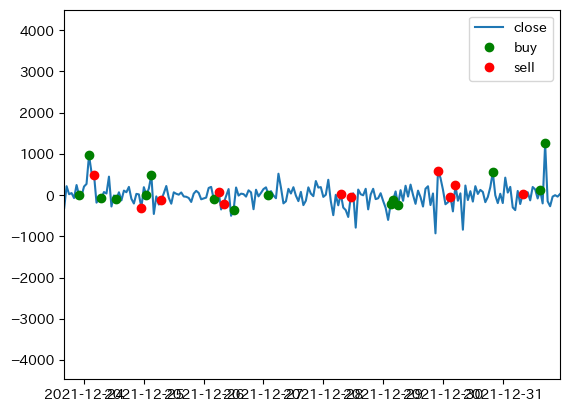

In [ ]:
print(df_calc["side"].value_counts())
plt.plot(df_calc["close"],label="close")
plt.plot(df_calc["close"][np.where(df_calc["side"]==1,True,False)],"go",label="buy")
plt.plot(df_calc["close"][np.where(df_calc["side"]==-1,True,False)],"ro",label="sell")
plt.xlim(df_calc.index[-200],df_calc.index[-1])
plt.legend()
plt.show()

# メタラベリング（トリプルバリア）

In [ ]:
## AFML Snipet 3.2
def apply_triple_barrier(close, events, ptsl, molecule):
    # t1前に行われた場合は，ストップロス/利食いを実施．
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if ptsl[0] > 0:pt=ptsl[0]*events_['trgt']
    else:pt=pd.Series(index=events.index)
    if ptsl[1] > 0:sl=-ptsl[1]*events_['trgt']
    else:sl=pd.Series(index=events.index)
    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0 = close[loc:t1] #価格経路
        df0 = (df0/close[loc]-1)*events_.at[loc, 'side'] #リターン
        #ストップロスの最短タイミング
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()
        #利食いの最短タイミング
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()
    return out

def calc_label(s: pd.Series, pfm):
    if (min(s.t1, s.pt, s.sl) == s.pt or min(s.t1, s.pt, s.sl) == s.sl):
        return (pfm.ret[s.t1] / pfm.ret[s.name] -
                1) / abs(pfm.ret[s.t1] / pfm.ret[s.name] - 1)
    else:
        return 0

def get_ret_label(df, pfm):
    """
    df's columns are as follows
      - t1
      - pt
      - sl
    pfm's columns are as follows
      - r
      - daily_vol
    """
    return df.apply(lambda x: calc_label(x, pfm), axis=1)

In [ ]:
def make_second_labels(df,h=12):
    df_ = df.copy()

    df_["ret"] = (df_["close_raw"].diff(h).shift(-h)[:-h] /
                  df_["close_raw"][:-h]).rename('r')

    pfm = pd.concat([df_["ret"], df_["daily_vol"]], axis=1)

    t1 = pfm.index[h:]  #垂直バリアの設定
    trgt = pfm.daily_vol[:-h]  #水平バリアの設定(ここではdailyのボラティリティから水平バリアを作成)
    side = len(pfm[:-h]) * [1]  #サイドは買いに設定

    #トリプルバリア法
    close = df_.close_raw
    molecule = pfm.index[:-h]
    events = pd.DataFrame({
        't1': t1,
        'trgt': trgt,
        'side': side
    }, index=molecule)  #eventsの作成
    ptsl = [1, 1]

    #各バリアに触れた時のタイムスタンプを含むdataframeが返ってくる
    df_triple = apply_triple_barrier(close, events, ptsl, molecule)

    #最初にバリアを触れる時刻を更新(デフォルトは垂直バリアの時刻)
    df_triple['t1'] = df_triple.dropna(how='all').min(axis=1)

    #ラベリング(有効期間までに水平バリアに触れない場合は垂直バリアに触れた時点で損益計算(垂直バリアにあたったら0とラベリング)
    labels_triple = get_ret_label(df_triple, pfm)

    metalabel=pd.Series(labels_triple,index=df_triple.index,name="barrier")
    df_=df_.merge(metalabel,on="timestamp",how="left")
    df_["barrier"]=df_["barrier"].fillna(value=0)
    df_['metalabel'] = np.where(df_["barrier"]==df_["side"],1,0)

    return df_

In [ ]:
df_pred2=make_second_labels(df_calc,h=12)
df_pred2["metalabel"].value_counts()

1    10163
0     7304
Name: metalabel, dtype: int64

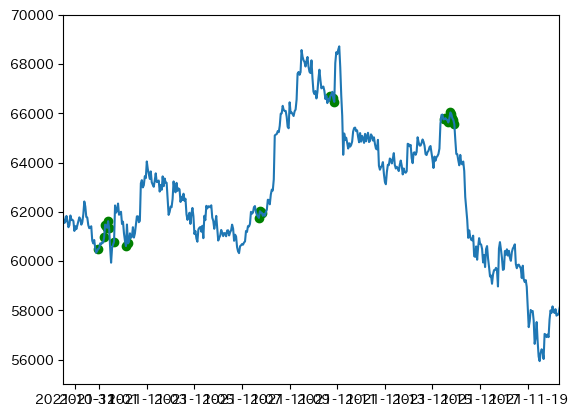

In [ ]:
plt.plot(df_pred2["close_raw"][np.where(df_pred2["barrier"]==1, True,False)],"go")
#plt.plot(df_pred2["close_raw"][np.where(df_pred2["barrier"]==-1, True,False)],"ro")
plt.plot(df_pred2["close_raw"])
plt.ylim(55000,70000)
plt.xlim(df_pred2.index[-1500],df_pred2.index[-1000])
plt.show()

In [ ]:
df_pred2.tail()

,open,high,low,close,volume,SMA5,SMA10,SMA25,WMA5,WMA10,...,close_raw,wma_sig,rsi_sig,bbands_sig,ichimoku_sig,signal_pow,side,ret,barrier,metalabel
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-12-31 19:00:00,-146.08,-107.62,-339.60,-267.44,11404.457,0.996642,0.989565,0.987296,0.999975,0.993923,...,48012.03,0,0,0,0,0,0,NaN,0.0,1
2021-12-31 20:00:00,-266.96,-237.95,31.87,-34.45,10649.207,0.999903,0.992081,0.988874,1.001574,0.996405,...,47977.58,0,0,0,0,0,0,NaN,0.0,1
2021-12-31 21:00:00,-34.46,-96.94,-85.68,0.41,8575.832,1.003267,0.994140,0.989270,1.001601,0.997838,...,47977.99,0,0,0,0,0,0,NaN,0.0,1
2021-12-31 22:00:00,-2.41,-25.00,66.37,-34.27,5718.212,1.001970,0.996433,0.990354,1.000989,0.999487,...,47943.72,0,0,0,0,0,0,NaN,0.0,1
2021-12-31 23:00:00,-31.45,65.18,-47.16,31.14,8919.171,1.000050,0.997139,0.990274,0.999899,0.999604,...,47974.86,0,0,0,0,0,0,NaN,0.0,1


17443 17455
ラベルリングの結果
 0.0    11387
-1.0     5351
 1.0      705
dtype: int64


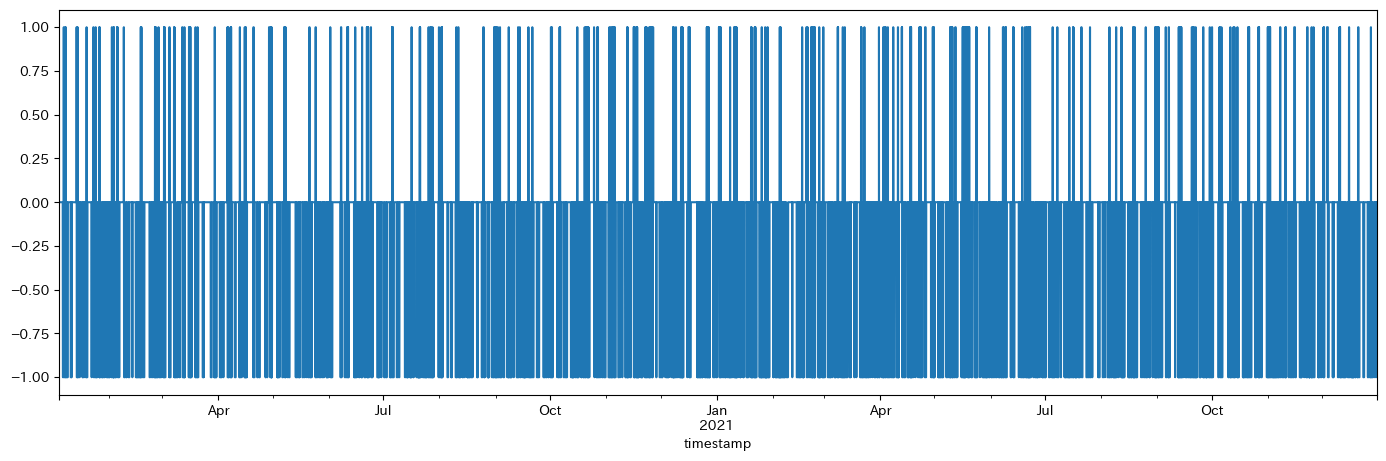

In [ ]:
h=12 #hours

df_calc["ret"] = (df_calc["close_raw"].diff(h).shift(-h)[:-h] /
                  df_calc["close_raw"][:-h]).rename('r')

df_calc=df_calc.dropna()
pfm = pd.concat([df_calc["ret"], df_calc["daily_vol"]], axis=1)

t1 = pfm.index[h:]  #垂直バリアの設定
trgt = pfm.daily_vol[:-h]  #水平バリアの設定(ここではdailyのボラティリティから水平バリアを作成)
side = len(pfm[:-h]) * [1]  #サイドは買いに設定

#トリプルバリア法
close = df_calc.close_raw
molecule = pfm.index[:-h]
events = pd.DataFrame({
    't1': t1,
    'trgt': trgt,
    'side': side
}, index=molecule)  #eventsの作成
ptsl = [1, 1]

#各バリアに触れた時のタイムスタンプを含むdataframeが返ってくる
df_triple = apply_triple_barrier(close, events, ptsl, molecule)

print(len(df_triple),len(df_calc))
#最初にバリアを触れる時刻を更新(デフォルトは垂直バリアの時刻)
df_triple['t1'] = df_triple.dropna(how='all').min(axis=1)

#ラベリング(有効期間までに水平バリアに触れない場合は垂直バリアに触れた時点で損益計算(垂直バリアにあたったら0とラベリング)
labels_triple = get_ret_label(df_triple, pfm)
print("ラベルリングの結果")
print(labels_triple.value_counts())
labels_triple.plot(figsize=(17, 5))
plt.show()

# 定常性確認

In [ ]:
def adf(df, cols, pct):
    """
    各特徴量に対してADF検定を行い，非定常な特徴量を返す関数

    Parameters
    ==========
    df: pandas dataframe
        特徴量が格納されたdataframe
    cols: list
        ADF検定を行う特徴量のカラム名が格納されたlist
    pct: '1%' or '5%' or '10%'
        信頼区間の幅を表すstr

    Returns
    =======
    unsteady_list: list
        非定常である特徴量の名前が格納されたlist
    """
    unsteady_list = []

    for col in tqdm(cols, total=len(cols)):
        stats = adfuller(df[col])
        test_stat_value = stats[0]
        critical_value = stats[4][pct]
        if test_stat_value > critical_value:
            unsteady_list.append(col)

    return unsteady_list

In [ ]:
unsteady_list = adf(df_calc, df_calc.columns, '5%')
print(f'元の特徴量の数: {len(df_calc.columns)}')
print(f'非定常な特徴量の数: {len(unsteady_list)}')
print(f'非定常な特徴量: \n{unsteady_list}')

100%|██████████| 53/53 [01:04<00:00,  1.22s/it]

元の特徴量の数: 53
非定常な特徴量の数: 1
非定常な特徴量: 
['close_raw']


# モデル作成

## エンバーゴ付きCPCV

In [ ]:
# 引用　https://www.kaggle.com/code/treename/janestreet-cv-method-combpurgedkfoldcv/notebook

class BaseTimeSeriesCrossValidator:
    """
    Abstract class for time series cross-validation.
    Time series cross-validation requires each sample has a prediction time pred_time, at which the features are used to
    predict the response, and an evaluation time eval_time, at which the response is known and the error can be
    computed. Importantly, it means that unlike in standard sklearn cross-validation, the samples X, response y,
    pred_times and eval_times must all be pandas dataframe/series having the same index. It is also assumed that the
    samples are time-ordered with respect to the prediction time (i.e. pred_times is non-decreasing).
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    """
    def __init__(self, n_splits=10):
        if not isinstance(n_splits, numbers.Integral):
            raise ValueError(f"The number of folds must be of Integral type. {n_splits} of type {type(n_splits)}"
                             f" was passed.")
        n_splits = int(n_splits)
        if n_splits <= 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting n_splits = 2 "
                             f"or more, got n_splits = {n_splits}.")
        self.n_splits = n_splits
        self.pred_times = None
        self.eval_times = None
        self.indices = None

    @abstractmethod
    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, pd.Series):
            raise ValueError('X should be a pandas DataFrame/Series.')
        if not isinstance(y, pd.Series) and y is not None:
            raise ValueError('y should be a pandas Series.')
        if not isinstance(pred_times, pd.Series):
            raise ValueError('pred_times should be a pandas Series.')
        if not isinstance(eval_times, pd.Series):
            raise ValueError('eval_times should be a pandas Series.')
        if y is not None and (X.index == y.index).sum() != len(y):
            raise ValueError('X and y must have the same index')
        if (X.index == pred_times.index).sum() != len(pred_times):
            raise ValueError('X and pred_times must have the same index')
        if (X.index == eval_times.index).sum() != len(eval_times):
            raise ValueError('X and eval_times must have the same index')

        self.pred_times = pred_times
        self.eval_times = eval_times
        self.indices = np.arange(X.shape[0])


class CombPurgedKFoldCV(BaseTimeSeriesCrossValidator):
    """
    Purged and embargoed combinatorial cross-validation
    As described in Advances in financial machine learning, Marcos Lopez de Prado, 2018.
    The samples are decomposed into n_splits folds containing equal numbers of samples, without shuffling. In each cross
    validation round, n_test_splits folds are used as the test set, while the other folds are used as the train set.
    There are as many rounds as n_test_splits folds among the n_splits folds.
    Each sample should be tagged with a prediction time pred_time and an evaluation time eval_time. The split is such
    that the intervals [pred_times, eval_times] associated to samples in the train and test set do not overlap. (The
    overlapping samples are dropped.) In addition, an "embargo" period is defined, giving the minimal time between an
    evaluation time in the test set and a prediction time in the training set. This is to avoid, in the presence of
    temporal correlation, a contamination of the test set by the train set.
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    n_test_splits : int, default=2
        Number of folds used in the test set. Must be at least 1.
    embargo_td : pd.Timedelta, default=0
        Embargo period (see explanations above).
    """
    def __init__(self, n_splits=10, n_test_splits=2, embargo_td=0):
        super().__init__(n_splits)
        if not isinstance(n_test_splits, numbers.Integral):
            raise ValueError(f"The number of test folds must be of Integral type. {n_test_splits} of type "
                             f"{type(n_test_splits)} was passed.")
        n_test_splits = int(n_test_splits)
        if n_test_splits <= 0 or n_test_splits > self.n_splits - 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"n_test_splits between 1 and n_splits - 1, got n_test_splits = {n_test_splits}.")
        self.n_test_splits = n_test_splits

        if embargo_td < 0:
            raise ValueError(f"The embargo time should be positive, got embargo = {embargo_td}.")
        self.embargo_td = embargo_td

    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
        """
        Yield the indices of the train and test sets.
        Although the samples are passed in the form of a pandas dataframe, the indices returned are position indices,
        not labels.
        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features), required
            Samples. Only used to extract n_samples.
        y : pd.Series, not used, inherited from _BaseKFold
        pred_times : pd.Series, shape (n_samples,), required
            Times at which predictions are made. pred_times.index has to coincide with X.index.
        eval_times : pd.Series, shape (n_samples,), required
            Times at which the response becomes available and the error can be computed. eval_times.index has to
            coincide with X.index.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        """
        super().split(X, y, pred_times, eval_times)

        # Fold boundaries
        fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(self.indices, self.n_splits)]
        # List of all combinations of n_test_splits folds selected to become test sets
        selected_fold_bounds = list(itt.combinations(fold_bounds, self.n_test_splits))

        # In order for the first round to have its whole test set at the end of the dataset
        selected_fold_bounds.reverse()

        for fold_bound_list in selected_fold_bounds:
            # Computes the bounds of the test set, and the corresponding indices
            test_fold_bounds, test_indices = self.compute_test_set(fold_bound_list)
            # Computes the train set indices
            train_indices = self.compute_train_set(test_fold_bounds, test_indices)

            yield train_indices, test_indices

    def compute_train_set(self, test_fold_bounds: List[Tuple[int, int]], test_indices: np.ndarray) -> np.ndarray:
        """
        Compute the position indices of samples in the train set.
        Parameters
        ----------
        test_fold_bounds : List of tuples of position indices
            Each tuple records the bounds of a block of indices in the test set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        """
        # As a first approximation, the train set is the complement of the test set
        train_indices = np.setdiff1d(self.indices, test_indices)
        # But we now have to purge and embargo
        for test_fold_start, test_fold_end in test_fold_bounds:
            # Purge
            train_indices = purge(self, train_indices, test_fold_start, test_fold_end)
            # Embargo
            train_indices = embargo(self, train_indices, test_indices, test_fold_end)
        return train_indices

    def compute_test_set(self, fold_bound_list: List[Tuple[int, int]]) -> Tuple[List[Tuple[int, int]], np.ndarray]:
        """
        Compute the indices of the samples in the test set.
        Parameters
        ----------
        fold_bound_list: List of tuples of position indices
            Each tuple records the bounds of the folds belonging to the test set.
        Returns
        -------
        test_fold_bounds: List of tuples of position indices
            Like fold_bound_list, but with the neighboring folds in the test set merged.
        test_indices: np.ndarray
            A numpy array containing the test indices.
        """
        test_indices = np.empty(0)
        test_fold_bounds = []
        for fold_start, fold_end in fold_bound_list:
            # Records the boundaries of the current test split
            if not test_fold_bounds or fold_start != test_fold_bounds[-1][-1]:
                test_fold_bounds.append((fold_start, fold_end))
            # If the current test split is contiguous to the previous one, simply updates the endpoint
            elif fold_start == test_fold_bounds[-1][-1]:
                test_fold_bounds[-1] = (test_fold_bounds[-1][0], fold_end)
            test_indices = np.union1d(test_indices, self.indices[fold_start:fold_end]).astype(int)
        return test_fold_bounds, test_indices


def compute_fold_bounds(cv: BaseTimeSeriesCrossValidator, split_by_time: bool) -> List[int]:
    """
    Compute a list containing the fold (left) boundaries.
    Parameters
    ----------
    cv: BaseTimeSeriesCrossValidator
        Cross-validation object for which the bounds need to be computed.
    split_by_time: bool
        If False, the folds contain an (approximately) equal number of samples. If True, the folds span identical
        time intervals.
    """
    if split_by_time:
        full_time_span = cv.pred_times.max() - cv.pred_times.min()
        fold_time_span = full_time_span / cv.n_splits
        fold_bounds_times = [cv.pred_times.iloc[0] + fold_time_span * n for n in range(cv.n_splits)]
        return cv.pred_times.searchsorted(fold_bounds_times)
    else:
        return [fold[0] for fold in np.array_split(cv.indices, cv.n_splits)]


def embargo(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
            test_indices: np.ndarray, test_fold_end: int) -> np.ndarray:
    """
    Apply the embargo procedure to part of the train set.
    This amounts to dropping the train set samples whose prediction time occurs within self.embargo_dt of the test
    set sample evaluation times. This method applies the embargo only to the part of the training set immediately
    following the end of the test set determined by test_fold_end.
    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times, cv.embargo_dt and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_indices : np.ndarray
        A numpy array containing all the indices of the samples in the test set.
    test_fold_end : int
        Index corresponding to the end of a test set block.
    Returns
    -------
    train_indices: np.ndarray
        The same array, with the indices subject to embargo removed.
    """
    if not hasattr(cv, 'embargo_td'):
        raise ValueError("The passed cross-validation object should have a member cv.embargo_td defining the embargo"
                         "time.")
    last_test_eval_time = cv.eval_times.iloc[cv.indices[:test_fold_end]].max()
    min_train_index = len(cv.pred_times[cv.pred_times <= last_test_eval_time + cv.embargo_td])
    if min_train_index < cv.indices.shape[0]:
        allowed_indices = np.concatenate((cv.indices[:test_fold_end], cv.indices[min_train_index:]))
        train_indices = np.intersect1d(train_indices, allowed_indices)
    return train_indices


def purge(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
          test_fold_start: int, test_fold_end: int) -> np.ndarray:
    """
    Purge part of the train set.
    Given a left boundary index test_fold_start of the test set, this method removes from the train set all the
    samples whose evaluation time is posterior to the prediction time of the first test sample after the boundary.
    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_fold_start : int
        Index corresponding to the start of a test set block.
    test_fold_end : int
        Index corresponding to the end of the same test set block.
    Returns
    -------
    train_indices: np.ndarray
        A numpy array containing the train indices purged at test_fold_start.
    """
    time_test_fold_start = cv.pred_times.iloc[test_fold_start]
    # The train indices before the start of the test fold, purged.
    train_indices_1 = np.intersect1d(train_indices, cv.indices[cv.eval_times < time_test_fold_start])
    # The train indices after the end of the test fold.
    train_indices_2 = np.intersect1d(train_indices, cv.indices[test_fold_end:])


    return np.concatenate((train_indices_1, train_indices_2))

In [ ]:
def plot_cv(df, train_idx, test_idx, i, n=5, figsize=(10, 7)):
    plt.figure(figsize=figsize)
    plt.subplot(n, 1, i)
    plt.axis([
        df.index.min(),
        df.index.max(),
        df.close.min() * 0.99,
        df.close.max() * 1.01
    ])
    plt.plot(df.iloc[train_idx].close,
             ls='',
             marker='o',
             markersize=1,
             label='train')
    plt.plot(df.iloc[test_idx].close,
             ls='',
             marker='o',
             markersize=1,
             label='test')
    plt.tight_layout()
    plt.legend()

In [ ]:
def cpcv(df,n_split=5,n_purge=5,n_test_splits=2):
  embargo_td=int(len(df)*0.01)

  t1_ = df.reset_index().index
  t1 = pd.Series(t1_).shift(n_purge).fillna(0).astype(int)
  t2 = pd.Series(t1_).shift(-n_purge).fillna(1e12).astype(int)

  cpcv = CombPurgedKFoldCV(n_splits=n_split, n_test_splits=n_test_splits, embargo_td=embargo_td)

  cv = list(cpcv.split(df.reset_index(), pred_times=t1, eval_times=t2))

  return cv

グループ数5
交差検証の組み合わせ数10.0


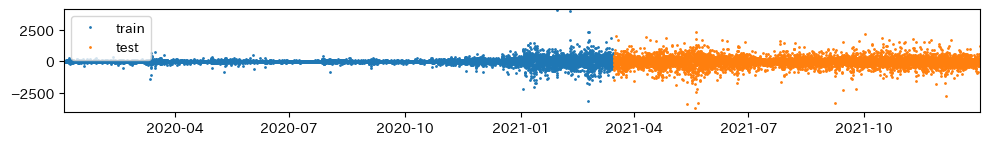

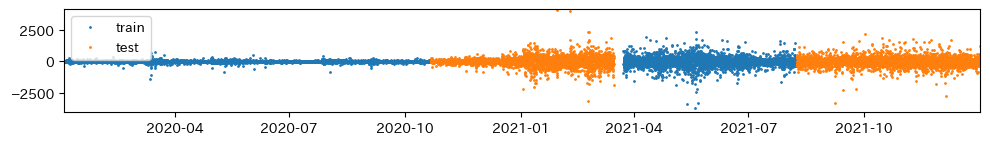

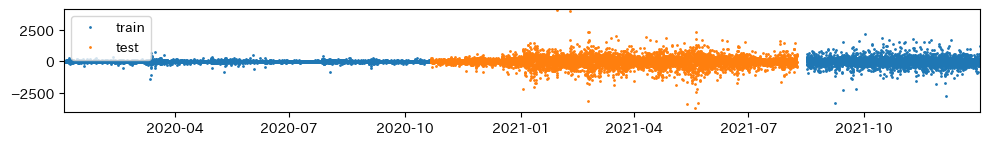

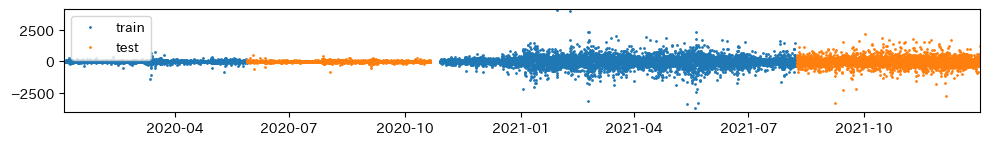

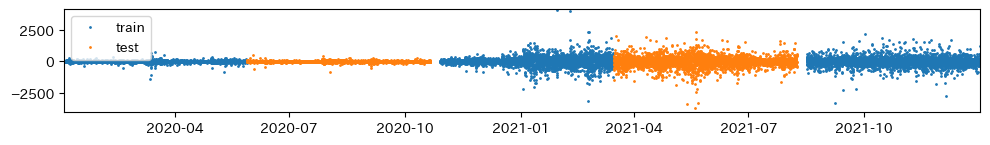

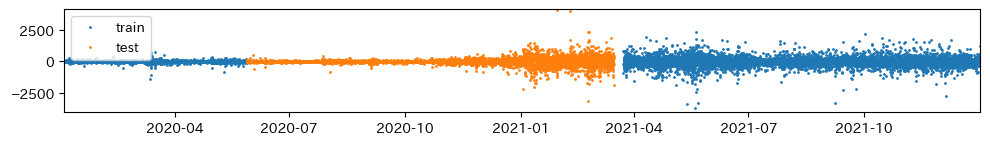

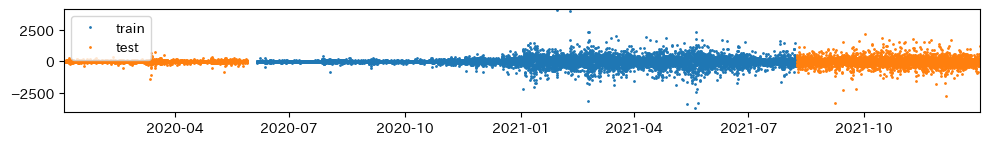

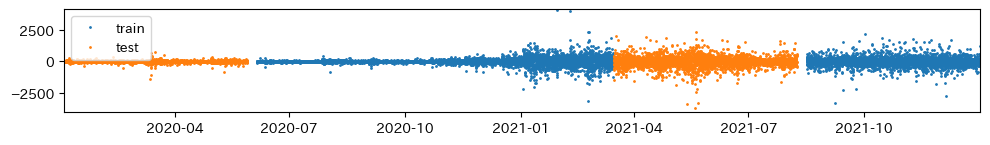

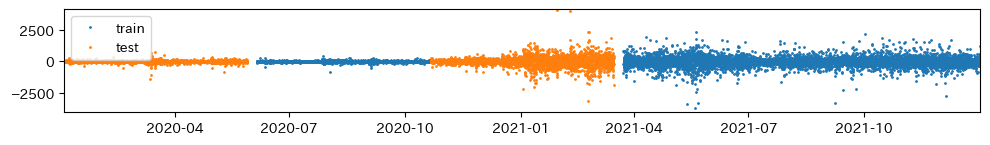

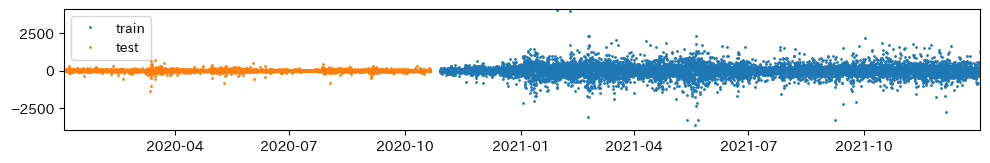

In [ ]:
n_split=5
n_test_splits=2
n_purge = 5

cv = cpcv(df_pred2,n_split,n_purge,n_test_splits)

i = 1
print(f'グループ数{n_split}')
print(f'交差検証の組み合わせ数{n_split*(n_split-1)/2}')
for train_idx, val_idx in cv:
    plot_cv(df_pred2,
            train_idx,
            val_idx,
            i=i,
            n=int(n_split * (n_split - 1) / 2),
            figsize=(10, 14))
    i += 1
plt.show()

In [ ]:
def training(df, features, y, model, n_split=5, n_purge=10,n_test_splits=2):
    """
    CPCVによりモデルを学習させ，各学習済みモデルによる予測を作成する関数

    Parameters
    ==========
    df: pandas dataframe
        特徴量とラベルが格納されたdataframe
    features: list
        モデルの学習に用いる特徴量の名前(str)が格納されたlist
    y: str
        モデルの学習に用いるラベルの名前
    model:
        学習に用いるモデル
    n_split: int
        cpcvの分割数
    n_purge: int
        パージングするレコード数

    Returns
    ==========
    ret: pandas dataframe
        二次モデルの予測が格納されたdataframe
    """
    cv = cpcv(df, n_split=n_split, n_purge=n_purge,n_test_splits=n_test_splits)

    # 一次モデルの出力を二次モデルの学習に用いる
    features_ = copy.deepcopy(features)

    # 結果格納用のDataFrame
    ret = df[[y]].copy()
    ret['probability'] = [0] * len(ret)
    for train_idx, val_idx in cv:
        train_idx = df.index[train_idx]
        val_idx = df.index[val_idx]
        # 学習データを用いてモデルを学習する
        model.fit(df.loc[train_idx, features_], df.loc[train_idx, y])
        # 検証データに対する予測を格納する
        ret.loc[val_idx, 'probability'] = model.predict(df.loc[val_idx, features_])[:]

    return ret

## LightGBM

In [ ]:
class LightGBM():
    def __init__(self,params,categorical_features):
        self.params=params
        self.category=categorical_features
    def fit(self,tr_x,tr_y):
        lgb_train=LGB.Dataset(tr_x,tr_y)
        lgb=LGB.train(
            self.params,lgb_train,categorical_feature=self.category
        )
        self.model=lgb
    def predict(self,va_x):
        return self.model.predict(va_x)

In [ ]:
def run(trial, df, features):

    # 変更してみてください．
    num_leaves = trial.suggest_int('num_leaves', 100, 300,step=50)

    params={
    'objective':'binary','metric':'rmse',
    'verbose':-1,"num_leaves":num_leaves,'seed':42,
    }

    lgb=LightGBM(
        params,
        ["wma_sig","rsi_sig","bbands_sig","ichimoku_sig","signal_pow","side"]
    )

    Xy = df.dropna(axis=0)
    ret = training(Xy, features, 'metalabel', model=lgb, n_split=5, n_purge=10)
    Xy = pd.concat([Xy, ret], axis=1)
    criterion = log_loss(ret['metalabel'].values, ret['probability'].values)

    return criterion

## LSTM

https://disassemble-channel.com/lstm-multivariate-time-series/

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn,optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torch.autograd import Variable

In [ ]:
catcol=["close_raw","wma_sig","rsi_sig","bbands_sig","ichimoku_sig","signal_pow"]
scaler=MinMaxScaler(feature_range=(0,1))
lstm_feat=[f for f in features if f not in catcol]
data_ml=scaler.fit_transform(df_pred2[lstm_feat])
side_dat=(df_pred2["side"]/2+0.5).values.reshape(-1,1)
data_ml=np.concatenate([data_ml,side_dat],1)
label=df_pred2["metalabel"]

df_train, df_test, label_train, label_test = train_test_split(data_ml,label, test_size=0.3, shuffle=False)
window_size = 360
n_data = len(df_pred2) - window_size + 1 -1

n_dim = df_train.shape[1]
n_train = len(df_train) - window_size + 1 - 1
n_test = len(df_test) - window_size + 1 - 1

# 正解データを準備
train = np.zeros((n_train, window_size, n_dim))
train_labels = np.zeros((n_train,1))
for i in range(n_train):
    train[i] = df_train[i:i+window_size]
    train_labels[i] = label_train[i+window_size]

# テストデータを準備
test = np.zeros((n_test, window_size, n_dim))
test_labels = np.zeros((n_test,1))
for i in range(n_test):
    test[i] = df_test[i:i+window_size]
    test_labels[i] = label_test[i+window_size]

In [ ]:
train = torch.tensor(train, dtype=torch.float)
train_labels = torch.tensor(train_labels, dtype=torch.float)
train_dataset = torch.utils.data.TensorDataset(train, train_labels)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test = torch.tensor(test, dtype=torch.float)
test_labels = torch.tensor(test_labels, dtype=torch.float)
test_dataset = torch.utils.data.TensorDataset(test, test_labels)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [ ]:
class MyLSTM(nn.Module):
    def __init__(self, feature_size, hidden_dim, n_layers):
        super(MyLSTM, self).__init__()

        self.feature_size = feature_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_output = 1

        self.lstm = nn.LSTM(feature_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, self.n_output)

    def forward(self, x):
        device = torch.device("cuda:0" if torch.cuda. is_available() else "cpu")
        # hidden state
        h_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim)).to(device)
        # cell state
        c_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim)).to(device)

        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_dim)
        y = self.fc(hn)
        y = (y+y)/2

        return y

feature_size  = len(lstm_feat)+1
n_hidden  = 256
n_layers  = 1

net = MyLSTM(feature_size, n_hidden, n_layers)

In [ ]:
func_loss = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
device = torch.device("cuda:0" if torch.cuda. is_available() else "cpu")
epochs = 25

net.to(device)

MyLSTM(
  (lstm): LSTM(47, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
train_loss,test_loss=[],[]
for i in tqdm(range(epochs)):
  for cond in ["train","test"]:
    if cond=="train":
      net.train()
    else:
      net.eval()
    tmp_loss = 0.0
    loader=train_loader if cond=="train" else test_loader
    for j, (x, t) in enumerate(loader):
        x = x.to(device)
        optimizer.zero_grad()
        y = net(x)
        y = y.to('cpu')
        loss = func_loss(y, t)
        if cond=="train":
          loss.backward()
          optimizer.step()
        tmp_loss += loss.item()
    tmp_loss /= j+1
    if cond=="train":
      train_loss.append(tmp_loss)
    else:
      test_loss.append(tmp_loss)
  #print('Epoch:', i, 'Loss_Train:',train_loss[-1], 'Loss_Test:',test_loss[-1])

100%|██████████| 25/25 [23:01<00:00, 55.24s/it]


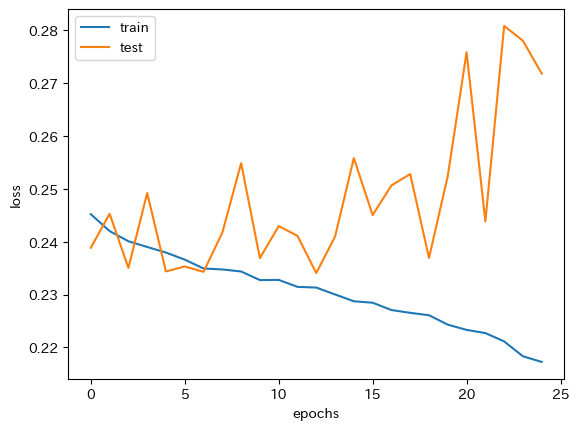

In [ ]:
plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(test_loss)), test_loss, label='test')
plt.legend()
#plt.xlim(0,20)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# 提出用コードの作成

##Preprocess関数

In [ ]:
def preprocess(df):

    train_df = calc_features(df)

    return train_df

## Get-Model関数

In [ ]:
def make_models(df, features, best_params, y,n_purge=10,n_split=5,n_test_split=2):
    """
    与えられたベストパラメータを用いてPurged CVにより学習済みモデルを作成する関数

    Parameters
    ==========
    df: pandas dataframe
        特徴量とラベルが格納されたdataframe
    features: list
        モデルの学習に用いる特徴量の名前(str)が格納されたlist
    y: str
        モデルの学習に用いるラベルの名前
    best_params: dictionary
        探索で得たモデルのベストパラメータ

    Return
    ======
    models: list
        学習済みモデルを格納したリスト
    """

    models = []
    cv = cpcv(df, n_split=n_split, n_purge=n_purge,n_test_splits=n_test_splits)
    features_ = copy.deepcopy(features)
    df_ = copy.deepcopy(df)

    params={
    'objective':'binary','metric':'rmse',
    'verbose':-1,"num_leaves":best_params["num_leaves"],'seed':42,
    }

    for train_idx, val_idx in cv:
        model=LightGBM(
            params,
            ["wma_sig","rsi_sig","bbands_sig","ichimoku_sig","signal_pow","side"]
        )
        train_idx = df_.index[train_idx]
        val_idx = df_.index[val_idx]

        # 学習データを用いてモデルを学習する
        model.fit(df_.loc[train_idx, features_], df_.loc[train_idx, y])

        models.append(model)

    return models

In [ ]:
def get_model(train_subsets):
    """
    与えられた日付の範囲のデータを加工し，学習済みモデルを生成する関数

    Parameters
    ==========
    train_subsets: list
        CPCVによって区切られた期間のうち、学習期間のデータが(加工前データ, 加工後データ)のタプルで
        格納されているlist

    Returns
    =======
    models: list
        CVにより分割された各foldのデータを用いて作成された学習済みモデルが格納されたリスト
    """
    train_df_subsets = [t[1] for t in train_subsets]
    train_df = pd.concat(train_df_subsets, axis=0)
    features = train_df.columns.to_list()
    features = [f for f in features if f!="close_raw"]

    print('making second labels')
    h=12 #12hours
    train_df = make_second_labels(train_df,h=h)

    print('seaching best parameters')
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(lambda trial: run(trial, train_df, features), n_trials=5, show_progress_bar=False)
    best_params = study.best_params
    print(f'best_params: {best_params}')

    print('creating models')
    models = make_models(train_df, features, best_params, y='metalabel')

    print('done')

    return models

In [ ]:
start = 0
end = 2000

In [ ]:
raw_df = pd.read_pickle('/content/drive/MyDrive/松尾研サマースクール/Day05/data/public.pkl')
train_df = preprocess(raw_df.iloc[start:end])
train_subsets = [(raw_df, train_df)]
models = get_model(train_subsets)

making second labels
seaching best parameters
best_params: {'num_leaves': 150}
creating models
done


In [ ]:
models

## Get-Signal関数

In [ ]:
def make_second_prediction(df, features, models):
    """
    加工済みデータと学習済みモデルを受け取り，2次モデルの出力を返す関数

    Parameters
    ==========
    df: pandas dataframe
        特徴量と1次モデルの予測が格納されたdataframe
    features: list
        モデルの推論に用いる特徴量の名前(str)が格納されたlist
    models: list
        学習済みモデル， 学習に用いたデータの範囲の情報が格納されたリスト

    Returns
    =======
    df_: pandas dataframe
        2次モデルの予測が'probability'カラムに格納されたdataframe
    """

    df_ = df.copy()
    df_["probability"]=np.zeros(len(df_))
    for model in models:
      df_["probability"]+=model.predict(df_.loc[:, features])[:]
    df_['probability'] = df_["probability"]/len(models)

    return df_

In [ ]:
def get_signal(preprocessed_df: pd.DataFrame, models: list=None):
    """
    preprocessed_dfを使ってシグナルを作成する関数

    Parameters
    ==========
    preprocessed_df: pd.DataFrame
        preprocess関数により前処理が施されたデータフレーム
    models: list
        get_modelの返り値. (optional)

    Returns
    =======
    df_: pd.DataFrame
        signal情報を持つpd.DataFrame
    """
    df_ = preprocessed_df.copy()
    features = df_.columns.to_list()
    features = [f for f in features if f!="close_raw"]

    if models:
        df_ = make_second_prediction(df_, features, models)
        # 閾値の0.2には特別な意味はありません．調整してみると良いかもしれません．
        df_['side'] = df_.apply(lambda row: row['side'] if row['probability'] > 0.2 else 0, axis=1)

    df_['order_flag'] = abs(df_['side'])

    return df_

## Get-Orders関数

In [ ]:
def get_orders(latest_timestamp, latest_bar, latest_signal, asset_info):
    """
    注文時刻，その時刻におけるポジションの状況，OHLCVから得たシグナルを元に注文を作成する関数

    Parameters
    ==========
    latest_timestamp: pandas.Timestamp
        注文を出す時刻
    latest_bar: pandas.Series
        注文を出す時刻のOHLCVデータ(加工前のデータ)
    latest_signal: pandas.Series
        注文を出す時刻のシグナルデータ(get_signal関数により作成されたデータ)
    asset_info: dict
        注文時におけるポジションの情報

    Returns
    =======
    order_lst: list (中身はOrderクラス)
        current_timeにおける注文情報が格納されている
        'type','side','size','price'の４項目
    """

    order_lst = []
    pos_size = asset_info.pos_size
    avg_price = asset_info.avg_price

    # max_position check
    lot_size_dollar = 10000
    max_lot = lot_size_dollar * 5
    position_price = pos_size * avg_price
    max_pos_flag = position_price > max_lot
    # profit-take and loss-cut check
    pt_lc_thre = 0.005
    pt_flag = latest_signal['close'] > avg_price * (1 + pt_lc_thre)
    lc_flag = latest_signal['close'] < avg_price * (1 - pt_lc_thre)

    if (pos_size != 0) and (max_pos_flag or pt_flag or lc_flag):
        if pos_size > 0:
            order_lst.append(Order('MARKET', 'SELL', abs(pos_size), None))
        elif pos_size < 0:
            order_lst.append(Order('MARKET', 'BUY', abs(pos_size), None))

    else:
        if latest_signal["order_flag"] == 1:
            order_size = lot_size_dollar / latest_signal["close_raw"]
            order_size = int(order_size / 0.1) * 0.1
            side = "BUY" if latest_signal["side"] == 1 else "SELL"
            order_lst.append(Order("MARKET", side, order_size, None))

    return order_lst

In [ ]:
start = 0
end = 2000
df_ = pd.read_pickle('/content/drive/MyDrive/松尾研サマースクール/Day05/data/public.pkl')

# asset_infoについてはバックテスターの内部で計算されるので，
# ここではこれまで取引がなかったものとして一時的にasset_infoを作成してみます．
asset_info = AssetInfo(
    nav = 1000000,
    margin = 1000000,
    rpnl = 0,
    upnl = 0,
    pos_size = 0,
    open_positions = [],
    commission = 0,
    avg_price = 0,
    total_pos_abs = 0,
    max_limit_total_pos_abs = 20,
    min_limit_margin = 0
)

In [ ]:
#latest_timestamp = df_.index[end]
#latest_bar = df_[df_.index == latest_timestamp].iloc[0]
df_preprocessed = preprocess(df_.iloc[start: end+1])
train_subsets = [(df_, df_preprocessed)]
models = get_model(train_subsets)
signals = get_signal(df_preprocessed, models)
latest_timestamp = signals.index[-1]
latest_bar = df_[df_.index == latest_timestamp].iloc[0]
latest_signal = signals[signals.index == latest_timestamp].iloc[0]
order = get_orders(latest_timestamp, latest_bar, latest_signal, asset_info)

making second labels
seaching best parameters
best_params: {'num_leaves': 150}
creating models
done


In [ ]:
print(order)

[]


## Strategyクラス

In [ ]:
class Strategy(BaseStrategy):
    def __init__(self, cfg) -> None:
        super().__init__(cfg)

    def preprocess(self, df):

        train_df = calc_features(df)

        return train_df

    def get_model(self, train_subsets):
        """
        与えられた日付の範囲のデータを加工し，学習済みモデルを生成する関数

        Parameters
        ==========
        train_subsets: list
            CPCVによって区切られた期間のうち、学習期間のデータが(加工前データ, 加工後データ)のタプルで
            格納されているlist

        Returns
        =======
        models: list
            CVにより分割された各foldのデータを用いて作成された学習済みモデルが格納されたリスト
        """
        train_df_subsets = [t[1] for t in train_subsets]
        train_df = pd.concat(train_df_subsets, axis=0)
        features = train_df.columns.to_list()
        features = [f for f in features if f!="close_raw"]

        # 二次モデルのラベルを作成する
        h=12 #12hours
        train_df = make_second_labels(train_df, h=h)

        # パラメータ探索を行う
        #study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
        #study.optimize(lambda trial: run(trial, train_df, features), n_trials=5, show_progress_bar=False)
        #best_params = study.best_params
        best_params={"num_leaves":150}

        # 探索結果のパラメータを用いてモデルを作成する
        models = make_models(train_df, features, best_params, y='metalabel',n_purge=10,n_split=5,n_test_split=2)

        return models

    def get_signal(self, preprocessed_df: pd.DataFrame, models: list=None):
        """
        preprocessed_dfを使ってシグナルを作成する関数

        Parameters
        ==========
        preprocessed_df: pd.DataFrame
            preprocess関数により前処理が施されたデータフレーム
        models: list
            get_modelの返り値. (optional)

        Returns
        =======
        df_: pd.DataFrame
            signal情報を持つpd.DataFrame
        """
        df_ = preprocessed_df.copy()
        features = df_.columns.to_list()
        features = [f for f in features if f!="close_raw"]

        if models:
            # 二次モデルによる予測を行う
            df_ = make_second_prediction(df_, features, models)
            # 閾値の0.2には特別な意味はありません．調整してみると良いかもしれません．
            df_['side'] = df_.apply(lambda row: row['side'] if row['probability'] > 0.85 else 0, axis=1)

        df_['order_flag'] = abs(df_['side'])

        return df_

    def get_orders(self, latest_timestamp, latest_bar, latest_signal, asset_info):
        """
        注文時刻，その時刻におけるポジションの状況，OHLCVから得たシグナルを元に注文を作成する関数

        Parameters
        ==========
        latest_timestamp: pandas.Timestamp
            注文を出す時刻
        latest_bar: pandas.Series
            注文を出す時刻のOHLCVデータ(加工前のデータ)
        latest_signal: pandas.Series
            注文を出す時刻のシグナルデータ(get_signal関数により作成されたデータ)
        asset_info: dict
            注文時におけるポジションの情報

        Returns
        =======
        order_lst: list (中身はOrderクラス)
            current_timeにおける注文情報が格納されている
            'type','side','size','price'の４項目
        """

        order_lst = []
        pos_size = asset_info.pos_size
        avg_price = asset_info.avg_price

        # 最大ポジションを設定し、現在のポジションがそれを超えてないかチェックする
        lot_size_dollar = 10000
        max_lot = lot_size_dollar * 5
        position_price = pos_size * avg_price
        max_pos_flag = position_price > max_lot
        # 利確と損切のフラグを作成する
        pt_lc_thre = 0.05
        pt_flag = latest_signal['close'] > avg_price * (1 + pt_lc_thre)
        lc_flag = latest_signal['close'] < avg_price * (1 - pt_lc_thre)

        if (pos_size != 0) and (max_pos_flag or pt_flag or lc_flag):
            # 最大ポジションまたは利確損切ラインに達しているとき
            # ポジションを解消する
            if pos_size > 0:
                order_lst.append(Order('MARKET', 'SELL', abs(pos_size), None))
            elif pos_size < 0:
                order_lst.append(Order('MARKET', 'BUY', abs(pos_size), None))

        # シグナルに従って発注を行う
        else:
            if latest_signal["order_flag"] == 1:
                order_size = lot_size_dollar / latest_signal["close_raw"]
                order_size = int(order_size / 0.1) * 0.1
                side = "BUY" if latest_signal["side"] == 1 else "SELL"
                order_lst.append(Order("MARKET", side, order_size, None))

        return order_lst

# back-test, run-test

In [ ]:
# 以下のcfgは初期設定から変更をしないようお願いいたします。
cfg = {
    'trade_config': {'leverage': 2,
                     'margin_rate': 0.5,
                     'minutes_to_expire': 60,
                     'margin': "100000USDT"},
    'backtester_config': {'start_date': datetime.date(2020, 1, 1),
                          'end_date': datetime.date(2021, 12, 31),
                          'use_wandb': False,
                          'save_model': True,
                          'exchange': 'binance',
                          'symbol': 'BTCUSDT',
                          'timeframe': '60min',
                          'min_timeframe': '60min',
                          'slippage': 0.01,
                          'delay': 0,
                          'max_lot': 1000,
                          'warmup_period': 500,
                          },
    'cv': {'type': 'cpcv', 'n_purge': 10, 'n_path': 4},
    'logging': {'plot': True,
                'level': 'INFO',
                'file': 'log/fin-backtester.log',
                'format': '%(asctime)s %(levelname)s %(message)s',
                'datefmt': '%Y-%m-%d %H:%M:%S'}
    }

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/松尾研サマースクール/Day05/data/public.pkl')
scoring = Scoring(
        config=cfg,
        Strategy=Strategy,
        raw_df=df,
    )
score = scoring.run()
print(f"mean score: {score}")
scoring.finish()

'2023年10月5日23時45分4秒時点での提出内容の採点結果です。'
'config:'
{
    'trade_config': {
        'leverage': 2,
        'margin_rate': 0.5,
        'minutes_to_expire': 60,
        'margin': 100000.0
    },
    'backtester_config': {
        'start_date': datetime.date(2020, 1, 1),
        'end_date': datetime.date(2021, 12, 31),
        'use_wandb': False,
        'save_model': True,
        'exchange': 'binance',
        'symbol': 'BTCUSDT',
        'timeframe': '60min',
        'min_timeframe': '60min',
        'slippage': 0.01,
        'delay': 0,
        'max_lot': 1000,
        'warmup_period': 500,
        'min_lot': 0.001,
        'is_linear': False,
        'maker_fee': 0.01,
        'taker_fee': 0.03,
        'pips': [
            {
                'start': None,
                'end': datetime.datetime(
                    year=2022,
                    month=2,
                    day=25,
                    hour=3,
                    minute=30
                ),
                'value': 0.

100%|██████████| 17521/17521 [00:16<00:00, 1058.17it/s]


'backtest 経路番号 : 0'
'----- summary -----'
'sharpe_ratio: 0'
'max_dd: 0.0'
'pnl/initial_margin: 0.0'
'max_dd_stime: 2020-01-01 01:00:00'
'max_dd_etime: 2020-01-01 01:00:00'
'nav: 100000.0'
'margin: 100000.0'
'commission: 0.0'
'rpnl: 0.0'
'upnl: 0.0'
'オーダー回数: 0'
'約定回数: 0'
'ポジションサイズの最大値: 0.0'
'ポジション保有時間: 0'
'勝率: 0'
'-------------------'
'backtest 経路番号 : 1'
'----- summary -----'
'sharpe_ratio: -0.6995987086872972'
'max_dd: -69.61630599999626'
'pnl/initial_margin: -0.000688822004'
'max_dd_stime: 2020-01-01 01:00:00'
'max_dd_etime: 2020-06-13 05:00:00'
'nav: 99931.1177996'
'margin: 99931.11779959999'
'commission: 11.0582004'
'rpnl: -57.824'
'upnl: 0.0'
'オーダー回数: 4'
'約定回数: 4'
'ポジションサイズの最大値: 1.0'
'平均ポジション保有時間: 0 days 01:00:00'
'勝率: 0.5'
'-------------------'
'Investment performance have been saved as a png file in log folder'


/usr/local/lib/python3.10/dist-packages/mlbacktester/stats/base_stats.py:140: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fills = fills.groupby("timestamp").sum()


'backtest 経路番号 : 2'
'----- summary -----'
'sharpe_ratio: -0.7071067811865475'
'max_dd: -45.0037147999974'
'pnl/initial_margin: -0.000450037148'
'max_dd_stime: 2020-01-01 01:00:00'
'max_dd_etime: 2021-08-24 03:00:00'
'nav: 99954.9962852'
'margin: 99954.9962852'
'commission: 5.9597148'
'rpnl: -39.044'
'upnl: 0.0'
'オーダー回数: 2'
'約定回数: 2'
'ポジションサイズの最大値: 0.2'
'平均ポジション保有時間: 0 days 01:00:00'
'勝率: 0.0'
'-------------------'
'Investment performance have been saved as a png file in log folder'


/usr/local/lib/python3.10/dist-packages/mlbacktester/stats/base_stats.py:140: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fills = fills.groupby("timestamp").sum()


'backtest 経路番号 : 3'
'----- summary -----'
'sharpe_ratio: -0.7977891212473921'
'max_dd: -90.21492939999735'
'pnl/initial_margin: -0.000902149294'
'max_dd_stime: 2020-01-01 01:00:00'
'max_dd_etime: 2021-11-01 15:00:00'
'nav: 99909.7850706'
'margin: 99909.7850706'
'commission: 14.8989294'
'rpnl: -75.316'
'upnl: 0.0'
'オーダー回数: 6'
'約定回数: 6'
'ポジションサイズの最大値: 0.8'
'平均ポジション保有時間: 0 days 01:00:00'
'勝率: 0.3333333333333333'
'-------------------'
'Investment performance have been saved as a png file in log folder'


/usr/local/lib/python3.10/dist-packages/mlbacktester/stats/base_stats.py:140: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fills = fills.groupby("timestamp").sum()


mean score: -0.00051


In [ ]:
# テスト対象のモジュールの読み込み
scoring = Scoring(
        config=cfg,
        Strategy=Strategy,
        raw_df=df,
    )
cfg = scoring.scoring.cfg
strategy = scoring.scoring.strategy
warmup_period = scoring.scoring.cfg["backtester_config"]["warmup_period"]
# 頻度コードから分に変換
td = pd.Timedelta(cfg["backtester_config"]["timeframe"])
timeframe = td.seconds // 60


# テスト用モジュールの読み込み


def load_raw_df():
    min_df = pd.read_pickle(cfg["backtester_config"]["data_path"])
    raw_df = bt.BackTester(cfg).data_initialize(min_df)
    return raw_df


def load_preprocessed_df(raw_df: pd.DataFrame):
    try:
        preprocessed_df = strategy.preprocess(raw_df.copy())
        print("Done : preprocess")
        return preprocessed_df
    except AttributeError:
        print("no preprocess function")
        return raw_df.copy()


def load_model(raw_df: pd.DataFrame, preprocessed_df: pd.DataFrame) -> Any:
    """preprocessed_dfを使ってモデルを作成する

    Args:
        preprocessed_df (pd.DataFrame): preprocessed_df
    """
    try:
        X = preprocessed_df.copy()
        model = strategy.get_model([(raw_df.copy(), X)])
        print("Done : get_model")
        return model
    except AttributeError:
        print("no get_model function")
        return None


def load_signal(preprocessed_df: pd.DataFrame, model: Any):
    X = preprocessed_df.copy()
    try:
        signal = strategy.get_signal(X, model)
        print("Done : get_signal")
        return signal
    except AttributeError:
        raise AttributeError("no get_signal function")


# テスト関数
def test_preprocess_timestamp(raw_df: pd.DataFrame, preprocessed_df: pd.DataFrame):
    """preprocessによって、最新の足が消えていないことを確認する
    forward testの時に最新の足が消えていると発注ができないため

    Args:
        raw_df (pd.DataFrame): raw_df
        preprocessed_df (pd.DataFrame): preprocess後のdata
    """
    latest_timestamp = preprocessed_df.index[-1]
    assert raw_df.index[-1] == latest_timestamp, "preprocessによって、最新の足が消えています"


def test_preprocess_leakage(raw_df: pd.DataFrame, preprocessed_df: pd.DataFrame):
    """
    forward testの場合に合わせて、preprocessをnum_of_candle本ずつ処理した結果と、一括処理した結果が一致することを確認する
    無限に過去を参照するような特徴量、未来の値を参照して計算された特徴量が含まれている場合はエラーを出すはず
    num_of_candleに対しての計算時間も記録する(長すぎると良くない)

    Args:
        raw_df (pd.DataFrame): time bar data
        preprocessed_df (pd.DataFrame): preprocess後のdata
    """
    try:
        # NOTE: 一括処理したpreprocessの結果
        batch_preprocessed_df = preprocessed_df.copy()
        # 1000本おきにpreprocessを行い、結果を比較する
        timer = []
        for ind in tqdm(
            range(
                cfg["backtester_config"]["warmup_period"] + 1,
                len(batch_preprocessed_df),
                1000,
            )
        ):
            latest_timestamp: pd.Timestamp = batch_preprocessed_df.index[ind]  # type: ignore
            # NOTE: forward testerの場合に合わせて,num_of_candle本ずつ処理したpreprocessの結果
            # num_of_candle本より前の情報および,latest_timestampより未来の情報を参照できない
            # この時の結果と一括処理した時の同一timestampの結果が一致することを確認する
            ind = raw_df.index.get_loc(latest_timestamp)
            start = time.time()
            online_preprocessed_df = strategy.preprocess(
                raw_df[
                    latest_timestamp
                    - timedelta(minutes=timeframe * warmup_period) : latest_timestamp
                ]
            )
            timer.append(time.time() - start)
            # 数値の列については、相対誤差が1e-4以下であることを確認する
            assert_frame_equal(
                batch_preprocessed_df[batch_preprocessed_df.index == latest_timestamp],
                online_preprocessed_df[
                    online_preprocessed_df.index == latest_timestamp
                ],
                check_dtype=False,
                check_exact=False,
                rtol=1e-4,
            )
        print(f"average processing time : {sum(timer)/len(timer):4f} sec")

    except AttributeError:
        raise AttributeError("error in preprocess function")


def test_signal_timestamp(signal: pd.DataFrame, preprocessed_df: pd.DataFrame):
    """signalによって、最新の足が消えていないことを確認する
    forward testの時に最新の足が消えていると発注ができないため

    Args:
        msignal (pd.DataFrame): signal
        preprocessed_df (pd.DataFrame): preprocess後のdata
    """
    latest_timestamp = preprocessed_df.index[-1]
    assert signal.index[-1] == latest_timestamp, "get_signalによって、最新の足が消えています"


# forward testerの場合に合わせて、signalsを逐次に処理した結果と、一括処理した結果が一致することを確認する
def test_signal_leakage(
    signal: pd.DataFrame,
    preprocessed_df: pd.DataFrame,
    model: Any,
):
    """forward testerの場合に合わせて、signalsを逐次に処理した結果と、一括処理した結果が一致することを確認する

    Args:
        signal (pd.DataFrame): signal
        preprocessed_df (pd.DataFrame): preprocessed data
        model (Any): モデル(get_modelの返り値)
    """
    try:
        # 一括処理した場合のm_signal
        batch_signal = signal.copy()
        # 一括処理して作成したm_signalと逐次処理で作成するm_signalの一致を1000本おきに確認する
        for ind in tqdm(
            range(
                cfg["backtester_config"]["warmup_period"] + 1, len(batch_signal), 1000
            )
        ):
            latest_timestamp = batch_signal.index[ind]
            # print("=====")
            # print(latest_timestamp)
            # print("=====")
            # NOTE: forward testerの場合に合わせて逐次処理したget_signalの結果
            # latest_timestampより未来の情報, num_of_candleより以前の情報は使用できない(forward
            # testerと同様の条件下)
            ind = preprocessed_df.index.get_loc(latest_timestamp)
            online_signal = strategy.get_signal(
                preprocessed_df[
                    latest_timestamp
                    - timedelta(minutes=timeframe * warmup_period) : latest_timestamp
                ].copy(),
                model,
            )
            # 一括処理したsignalと逐次処理したsignalの一致を確認する
            # 数値の列については、相対誤差が1e-4以下であることを確認する
            assert_frame_equal(
                batch_signal[batch_signal.index == latest_timestamp],
                online_signal[online_signal.index == latest_timestamp],
                check_dtype=False,
                check_exact=False,
                rtol=1e-4,
            )
    except AttributeError:
        raise AttributeError("error in get_signal function")


# テストの実行

raw_df = df
preprocessed_df = load_preprocessed_df(raw_df)
model = load_model(raw_df, preprocessed_df)
signal = load_signal(preprocessed_df, model)

test_preprocess_timestamp(raw_df, preprocessed_df)
test_preprocess_leakage(raw_df, preprocessed_df)
test_signal_timestamp(signal, preprocessed_df)
test_signal_leakage(signal, preprocessed_df, model)

print("\n PASS")

'2023年10月5日22時54分8秒時点での提出内容の採点結果です。'
Done : preprocess
Done : get_model
Done : get_signal


100%|██████████| 17/17 [00:01<00:00,  9.32it/s]


average processing time : 0.098711 sec


100%|██████████| 17/17 [00:01<00:00,  8.89it/s]


 PASS
